In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005

In [3]:
size = 100  # size of the 2D grid
dx = 2. / size  # space step

T = 20.0  # total time
dt = .001  # time step
n = int(T / dt)  # number of iterations


In [4]:
U = np.random.rand(size, size)
V = np.random.rand(size, size)
U_init = U
V_init = V

In [5]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

In [6]:
def show_patterns(U, ax=None):
    ax.imshow(U, cmap=plt.cm.copper,
              interpolation='bilinear',
              extent=[-1, 1, -1, 1])
    ax.set_axis_off()

In [ ]:
def turing_pde(U_vec, V_vec, dt, a, b, k, tau):
    U_vec[1:-1, 1:-1], V_vec[1:-1, 1:-1] = \
            Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
            Vc + dt * (b * deltaV + Uc - Vc) / tau
    return U_vec, V_vec

In [7]:
def solve_numerically(U_in, V_in, n, dt, a, b, k, tau, plot=False):
    U = copy.deepcopy(U_in)
    V = copy.deepcopy(V_in)
    if plot: 
        fig, axes = plt.subplots(3, 3, figsize=(8, 8))
        step_plot = n // 9
    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaU = laplacian(U)
        deltaV = laplacian(V)
        # We take the values of u and v inside the grid.
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # We update the variables.
        # U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        #     Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
        #     Vc + dt * (b * deltaV + Uc - Vc) / tau
        U[1:-1, 1:-1], V[1:-1, 1:-1] = turing_pde(Uc, Vc, dt, a, b, k, tau)
        # Neumann conditions: derivatives at the edges
        # are null.
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]
        
        if plot and i % step_plot == 0 and i < 9 * step_plot:
            ax = axes.flat[i // step_plot]
            show_patterns(U, ax=ax)
            ax.set_title(f'$t={i * dt:.2f}$')
    
    return U, V

<Figure size 432x288 with 0 Axes>

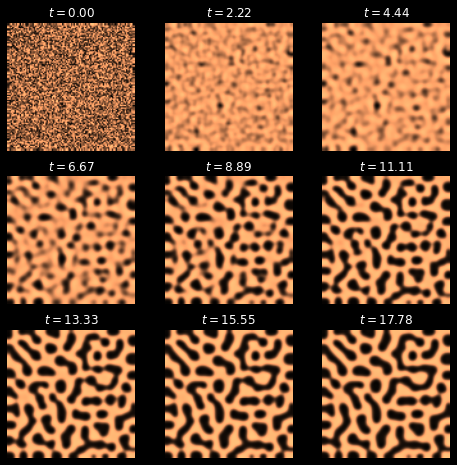

In [8]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005

# for a in np.arange(0.5e-4, 5.5e-4, 0.5e-4):               # increases in a decrease spatial frequency
# for b in np.arange(1e-3, 8e-3, 1e-3):                     # increases in b accelerate pattern formation
# for k in np.arange(-.1, 1, 0.1):                            # small variations dont change much, large variations change pattern type completely
# for tau in np.arange(0.1, 3., 0.3):                       # tau must be greater 0., large tau makes pattern very diffuse
plt.figure()
U, V = solve_numerically(U_init, V_init, n, dt, a, b, k, tau, plot=True)

In [9]:
def likelihood(samples, proposed_solution, var=0.1):
    p = (1/np.sqrt(2* np.pi * var**2)) * np.exp(-np.power(samples - proposed_solution, 2) / (2 * var**2))
    return np.prod(p)

In [10]:
def prior(params): 
    return 1.

In [11]:
def proposed_solution(U, V, n, dt, a, b, k, tau):
    return solve_numerically(U, V, n, dt, a, b, k, tau)

In [12]:
def posterior(samples, parameters):
    (a, b, k, tau) = parameters
    proposed_U, proposed_V = proposed_solution(U_init, V_init, n, dt, a, b, k, tau)
    l = likelihood(samples, np.concatenate((proposed_U, proposed_V)))
    p = prior(parameters)
    return l * p

In [13]:
def proposal_parameters(current_params, var=0.25):
    (a, b, k, tau) = current_params
    new_a = np.random.normal(a, 0.5e-4)
    new_b = np.random.normal(b, 1e-3)
    new_k = np.random.normal(k, 0.1)
    new_tau = np.random.normal(tau, 0.3)
    return (new_a, new_b, new_k, new_tau)  

In [14]:
def accept_reject_RWM(samples, current_params, proposed_params):
    ratio = posterior(samples, proposed_params) / posterior(samples, current_params)
    if ratio > np.random.uniform():
        return proposed_params
    else: 
        return current_params

In [15]:
def RWM_step(samples, current_params):
    proposed_params = proposal_parameters(current_params)
    new_params = accept_reject_RWM(samples, current_params, proposed_params)
    return new_params


In [16]:
iteration_nr = 10

a_initial = np.random.uniform(0.5e-4, 5.5e-4)
b_initial = np.random.uniform(1e-3, 8e-3)
k_initial = np.random.uniform(-.1, 1)
tau_intial = np.random.uniform(0.1, 3.)

current_params = (a_initial, b_initial, k_initial, tau_intial)
a_vec = []
b_vec = []
k_vec = []
tau_vec = []

for i in tqdm(range(iteration_nr)): 
    a_vec.append(current_params[0])
    b_vec.append(current_params[1])
    k_vec.append(current_params[2])
    tau_vec.append(current_params[3])

    current_params = RWM_step(np.concatenate((U, V)), current_params)
    

current_params


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-7-ca26bf00de7f>:16: RuntimeWarning: overflow encountered in power
  Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
<ipython-input-7-ca26bf00de7f>:16: RuntimeWarning: invalid value encountered in add
  Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
<ipython-input-7-ca26bf00de7f>:16: RuntimeWarning: invalid value encountered in subtract
  Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
<ipython-input-5-4fa2c5342cc4>:7: RuntimeWarning: invalid value encountered in add
  return (Ztop + Zleft + Zbottom + Zright -
<ipython-input-5-4fa2c5342cc4>:7: RuntimeWarning: invalid value encountered in subtract
  return (Ztop + Zleft + Zbottom + Zright -
<ipython-input-7-ca26bf00de7f>:17: RuntimeWarning: invalid value encountered in add
  Vc + dt * (b * deltaV + Uc - Vc) / tau
<ipython-input-5-4fa2c5342cc4>:7: RuntimeWarning: overflow encountered in true_divide
  return (Ztop + Zleft + Zbottom + Zright -
  2%|▏         | 2/100 [00:23<19:36, 12.00s/it

(0.0004118207988661874,
 0.0016404184536319248,
 0.7393839158358488,
 0.26872185130520027)

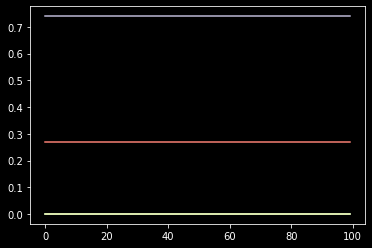

In [18]:
plt.plot(a_vec, label='a')
plt.plot(b_vec, label='b')
plt.plot(k_vec, label='k')
plt.plot(tau_vec, label='tau')